# Coursework 1: Convolutional Neural Networks
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Lab cluster, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

<font color="orange">**The deadline for submission is Tuesday, 6 Feb by 6 pm** </font>

In [135]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn

In [136]:
# Initialization Cell
try:
    WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        d1_cw1_repo_path = 'Imperial/Deep learning/DL_CW_1_mrb23/' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/{d1_cw1_repo_path}' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}dl_cw_1.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import torch
torch.cuda.is_available()

True

## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations.
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        if type(kernel_size) == int:
          self.kernel_size = (kernel_size, kernel_size)
        elif isinstance(kernel_size, tuple) and len(kernel_size) == 2:
          self.kernel_size = kernel_size
        else:
          raise TypeError('kernel_size should be an int or a tuple of two ints')

        if type(stride) == int:
          self.stride = (stride, stride)
        elif isinstance(stride, tuple) and len(stride) == 2:
          self.stride = stride
        else:
          raise TypeError('stride should be an int or a tuple of two ints')

        if type(padding) == int:
          self.padding = (padding, padding)
        elif isinstance(padding, tuple) and len(padding) == 2:
          self.padding = padding
        else:
          raise TypeError('padding should be an int or a tuple of two ints')
        # TODO: Define the parameters used in the forward pass
        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = torch.zeros([out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]])
        # Bias should have shape [out_channels]
        self.b = torch.zeros([out_channels])
        self.F = out_channels
        self.C = in_channels
        self.bias = bias

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass
        x_unf = F.unfold(x, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding)
        w_unf = self.w.view(self.F, -1, 1)

        out_unf = x_unf.transpose(1,2) @ self.w.view(self.F, -1).transpose(1, 0)
        if self.bias:
          out_unf = torch.add(out_unf, self.b)

        out_unf = out_unf.transpose(2,1)

        output_size_H = int((x.shape[2] - self.kernel_size[0] + 2*self.padding[0])/self.stride[0]) + 1
        output_size_W = int((x.shape[3] - self.kernel_size[1] + 2*self.padding[1])/self.stride[1]) + 1
        out = out_unf.view(x.shape[0], self.F, output_size_H, -1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [172]:
tensor = torch.tensor(([[[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,19,20],[21,22,23,24,25]],[[26,27,28,29,30],[31,32,33,34,35],[36,37,38,39,40],[41,42,43,44,45],[46,47,48,49,50]]]]), dtype = torch.float32)
window = torch.tensor([[[[1,0,0],[1,0,0]],[[1,0,0],[1,0,0]]],[[[1,0,0],[1,0,0]],[[1,0,0],[1,0,0]]]], dtype = torch.float32)
print(window.shape)
in_channels = tensor.shape[1]
out_channels = 2
kernel_size = (2,3)
padding = 0
stride = 1
weights = torch.rand((out_channels,in_channels, kernel_size[0], kernel_size[1]))
bias = torch.rand(out_channels)


torch_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride = stride, padding = padding, bias = False)
my_conv = Conv2d(in_channels, out_channels, kernel_size, stride = stride, padding = padding, bias=False)
# torch_conv.weights = window
torch_conv.biases = bias
# my_conv.w = window
my_conv.b = bias

print(tensor.shape)

print(torch_conv(tensor))
print(my_conv(tensor))
#assert torch_conv(tensor).shape == my_conv(tensor).shape



torch.Size([2, 2, 2, 3])
torch.Size([1, 2, 5, 5])
tensor([[[[-14.9846, -15.0038, -15.0230],
          [-15.0806, -15.0998, -15.1190],
          [-15.1766, -15.1958, -15.2150],
          [-15.2727, -15.2919, -15.3111]],

         [[ -6.0632,  -7.0508,  -8.0384],
          [-11.0012, -11.9888, -12.9765],
          [-15.9393, -16.9269, -17.9145],
          [-20.8773, -21.8649, -22.8526]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])


In [139]:
inp = torch.randn(1, 3, 10, 12)
w = torch.randn(2, 3, 4, 5)
inp_unf = torch.nn.functional.unfold(inp, (4, 5))
print(inp_unf.shape)
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = torch.nn.functional.fold(out_unf, (7, 8), (1, 1))
print(out.shape, out_unf.shape)
# or equivalently (and avoiding a copy),
# out = out_unf.view(1, 2, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()

torch.Size([1, 60, 56])
torch.Size([1, 2, 7, 8]) torch.Size([1, 2, 56])


tensor(3.8147e-06)

In [140]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if type(kernel_size) == int:
          self.kernel_size = (kernel_size, kernel_size)
        elif isinstance(kernel_size, tuple) and len(kernel_size) == 2:
          self.kernel_size = kernel_size
        else:
          raise TypeError('kernel_size should be an int or a tuple of two ints')
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        N = x.shape[0]
        C = x.shape[1]
        H = x.shape[2]
        W = x.shape[3]
        output_size_H = int((H-self.kernel_size[0])/self.kernel_size[0])+1
        output_size_W = int((W-self.kernel_size[1])/self.kernel_size[1])+1
        x_unf = F.unfold(x, kernel_size = self.kernel_size, stride = self.kernel_size).transpose(1,2)
        x_unf = x_unf.reshape(N, -1, self.kernel_size[0] * self.kernel_size[1]).transpose(1,2)
        max_x = torch.max(x_unf, 1)[0]

        out = max_x.reshape(N, -1, C).transpose(2,1).reshape(N, C, output_size_H, output_size_W)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [142]:
tensor = torch.tensor(([[[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15],[16,17,18,19,20],[21,22,23,24,25]],[[26,27,28,29,30],[31,32,33,34,35],[36,37,38,39,40],[41,42,43,44,45],[46,47,48,49,50]]]]), dtype = torch.float32)
x_unf = F.unfold(tensor, kernel_size = 2)

torch.max(x_unf, 1)

mp2 = MaxPool2d(2)
print(tensor.shape, mp2(tensor))

torch.Size([1, 2, 5, 5]) tensor([[[[ 7.,  9.],
          [17., 19.]],

         [[32., 34.],
          [42., 44.]]]])


In [143]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [144]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = torch.zeros([in_channels, out_channels])
        self.b = torch.zeros([out_channels])
        self.bias = bias
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        if self.bias:
          out = x @ self.w + self.b
        else:
          out = x @self.w

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [145]:
x = torch.tensor([[1,2,3,3]], dtype = torch.float32)
lin = Linear(4,2)
lin.w = torch.tensor([[0,0],[1,0],[0,1],[1,1]],dtype = torch.float32)
lin(x)

tensor([[5., 6.]])

In [146]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [205]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
		self.gamma = torch.ones([num_features])
		self.beta = torch.zeros([num_features])
		self.running_mean = torch.zeros(num_features)
		self.running_var = torch.zeros(num_features)
		self.num_inputs = 0
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		if self.training:
			batch_var, batch_avg = torch.var_mean(x, (0,2,3), unbiased = False, keepdim = True) #CHECK IF CORRECT UNBIASED
	 		#Update running mean and variance
			self.running_mean = self.momentum * batch_avg + (1-self.momentum) * self.running_mean
			self.running_var = self.momentum * batch_var + (1-self.momentum) * self.running_var
			#Normalise and incorporate gamma and beta
			x = (x - batch_avg) / torch.sqrt(batch_var + self.eps)
			x = self.gamma.view(1,self.num_features,1,1) * x + self.beta.view(1,self.num_features,1,1)
		else:
			x = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
			x = self.gamma.view(1,self.num_features,1,1) * x + self.beta.view(1,self.num_features,1,1)
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		return x

In [207]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (28 points)
    * 8 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (12 points)

**Downloading NaturalImageNet**

In [211]:
ON_COLAB = True

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else:
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2024-02-05 21:36:13--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5846979/files/NaturalImageNetTest.zip [following]
--2024-02-05 21:36:14--  https://zenodo.org/records/5846979/files/NaturalImageNetTest.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1.2’

NaturalImageNetTest 100%[===================>] 132.09M  17.1MB/s    in 9.5s    

2024-02-05 21:36:23 (14.0 MB/s) - ‘NaturalImageNetTest.zip?download=1.2’ saved [138507970/138507970]

--2024-02-05 21:36:24--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)...

In [156]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [218]:
# When we import the images we want to first convert them to a tensor.
# It is also common in deep learning to normalise the the inputs. This
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

#AUGMENT THE DATA

train_transform = transforms.Compose(
            [transforms.RandomApply([
            transforms.RandomRotation((-20,20)),
            transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 3)),
            transforms.RandomHorizontalFlip(),
        ], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
test_transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!
batch_size = 32

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [219]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images**

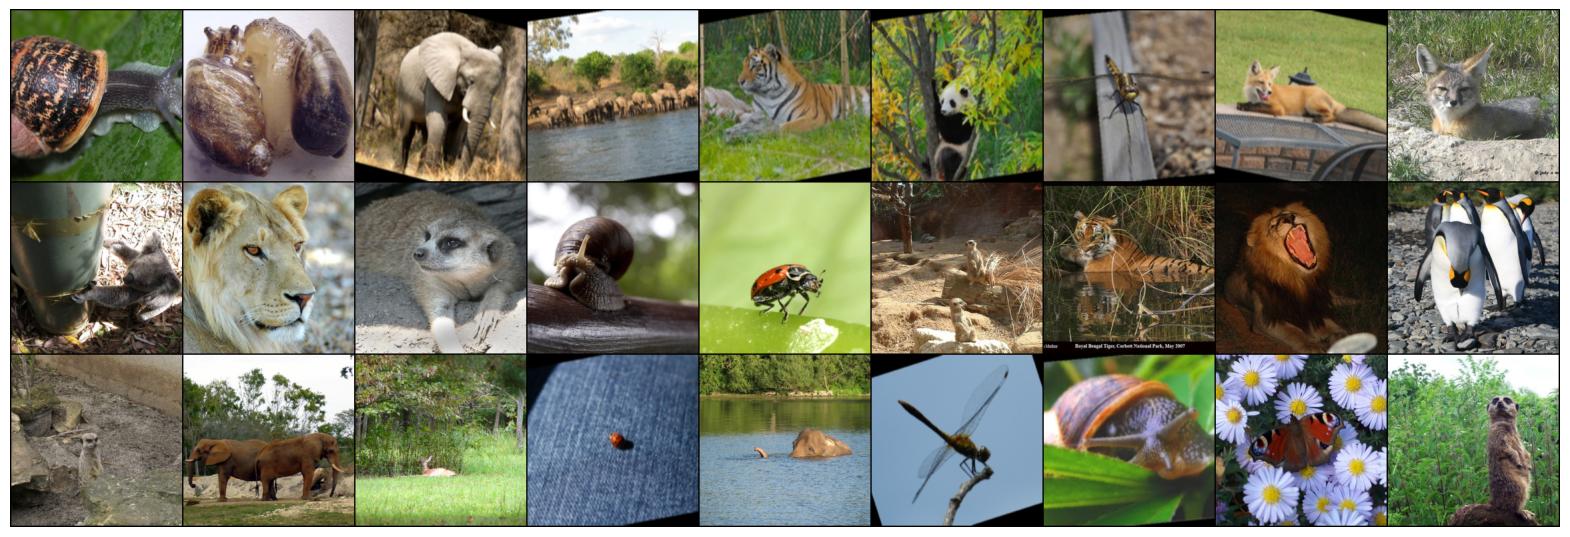

In [220]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [165]:
# define resnet building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  )

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = F.relu(out)

        return out



# define resnet

class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 20):

        super(ResNet, self).__init__()

        self.inchannel = 16
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU())

        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [162]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [163]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)



def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        check_accuracy(loader_val, model)


cuda:0


In [166]:
# define and train the network
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.0001)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 10)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

Total number of parameters is: 11204164
Epoch: 0, Iteration 0, loss = 5.5327
Epoch: 0, Iteration 10, loss = 3.0789
Epoch: 0, Iteration 20, loss = 2.9801
Epoch: 0, Iteration 30, loss = 2.9440
Epoch: 0, Iteration 40, loss = 2.7962
Epoch: 0, Iteration 50, loss = 2.6886
Epoch: 0, Iteration 60, loss = 2.8097
Epoch: 0, Iteration 70, loss = 2.7175
Epoch: 0, Iteration 80, loss = 2.6797
Epoch: 0, Iteration 90, loss = 2.6550
Epoch: 0, Iteration 100, loss = 2.7891
Epoch: 0, Iteration 110, loss = 2.5718
Epoch: 0, Iteration 120, loss = 2.6183
Epoch: 0, Iteration 130, loss = 2.6808
Epoch: 0, Iteration 140, loss = 2.6751
Got 529 / 1998 correct of val set (26.48)
Epoch: 1, Iteration 0, loss = 2.2067
Epoch: 1, Iteration 10, loss = 2.1484
Epoch: 1, Iteration 20, loss = 2.0897
Epoch: 1, Iteration 30, loss = 2.1759
Epoch: 1, Iteration 40, loss = 2.0394
Epoch: 1, Iteration 50, loss = 2.0356
Epoch: 1, Iteration 60, loss = 2.0363
Epoch: 1, Iteration 70, loss = 2.2475
Epoch: 1, Iteration 80, loss = 2.1239
Epo

KeyboardInterrupt: 

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 737 / 2000 correct of val set (36.85)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


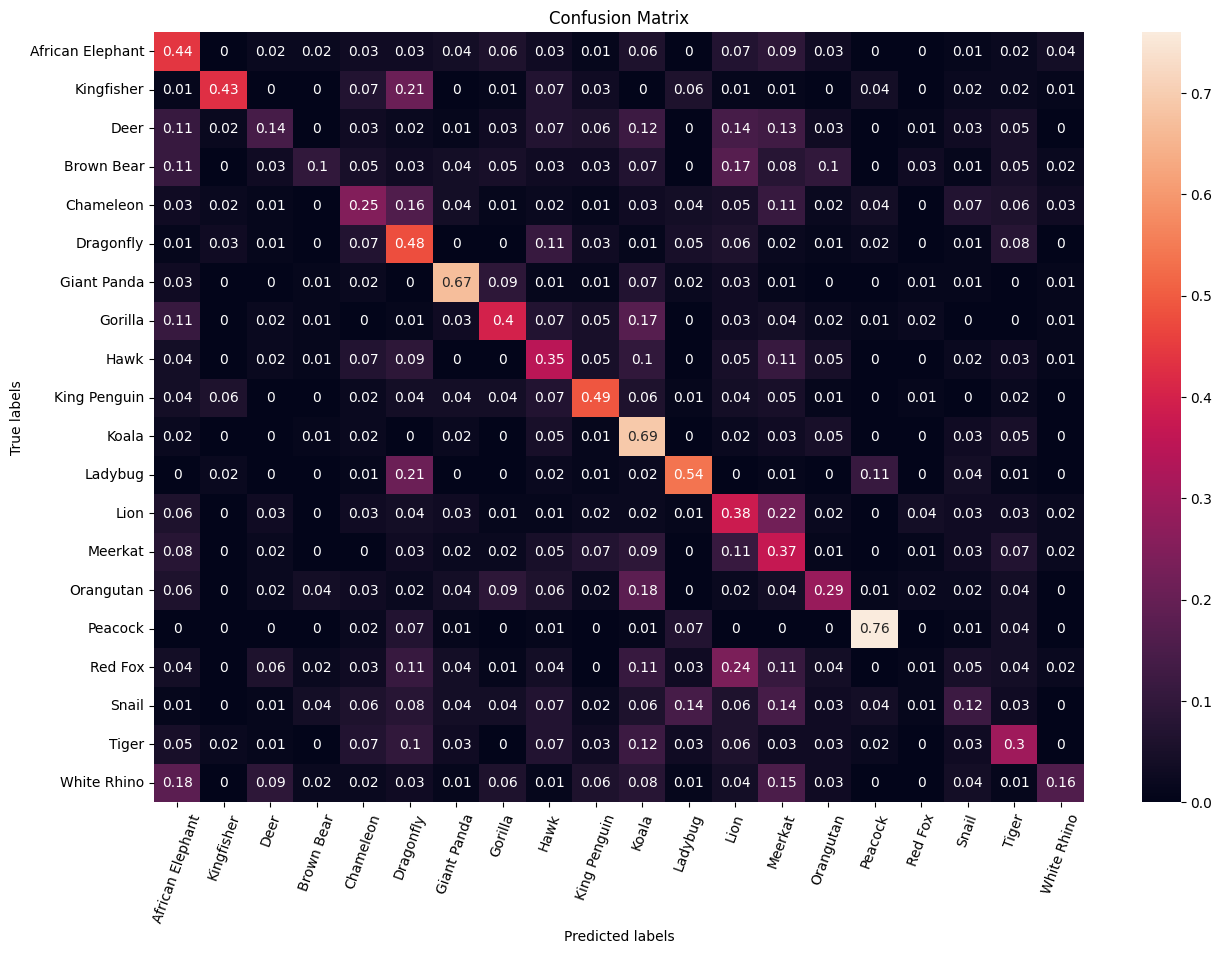

Predicted label ['Lion' 'King Penguin' 'Chameleon' 'Snail' 'Meerkat' 'Koala'
 'African Elephant' 'Hawk' 'Deer']
True label ['Snail' 'White Rhino' 'Red Fox' 'Dragonfly' 'African Elephant'
 'Orangutan' 'Meerkat' 'King Penguin' 'Brown Bear']
Corresponding images are shown below


0.3685

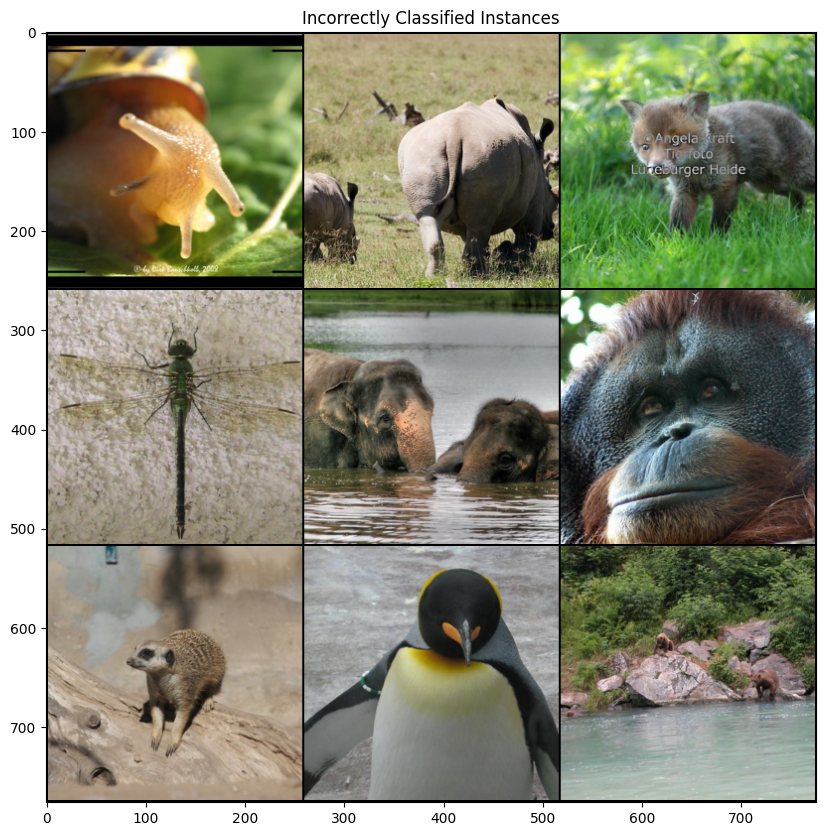

In [ ]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

- Data augmentation

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.3: Out of distribution evaluation

Lets see how your trained model performs when evaluated on cartoons of the 20 animal classes. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (2 points)

In [ ]:
ON_COLAB = True

!wget https://zenodo.org/records/10424022/files/cartoons.zip?download=1

if ON_COLAB:
    !unzip /content/cartoons.zip?download=1 > /dev/null

else:
    !unzip cartoons.zip?download=1 > /dev/null

--2024-02-04 22:59:55--  https://zenodo.org/records/10424022/files/cartoons.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737267 (1.7M) [application/octet-stream]
Saving to: ‘cartoons.zip?download=1’

cartoons.zip?downlo 100%[===================>]   1.66M  1.98MB/s    in 0.8s    

2024-02-04 22:59:57 (1.98 MB/s) - ‘cartoons.zip?download=1’ saved [1737267/1737267]



In [ ]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )
cartoon_path = ('/content/' if ON_COLAB else '') + 'cartoons'


cartoon_dataset = datasets.ImageFolder(cartoon_path, transform=transform)

print(len(cartoon_dataset))

batch_size = 128

cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

400


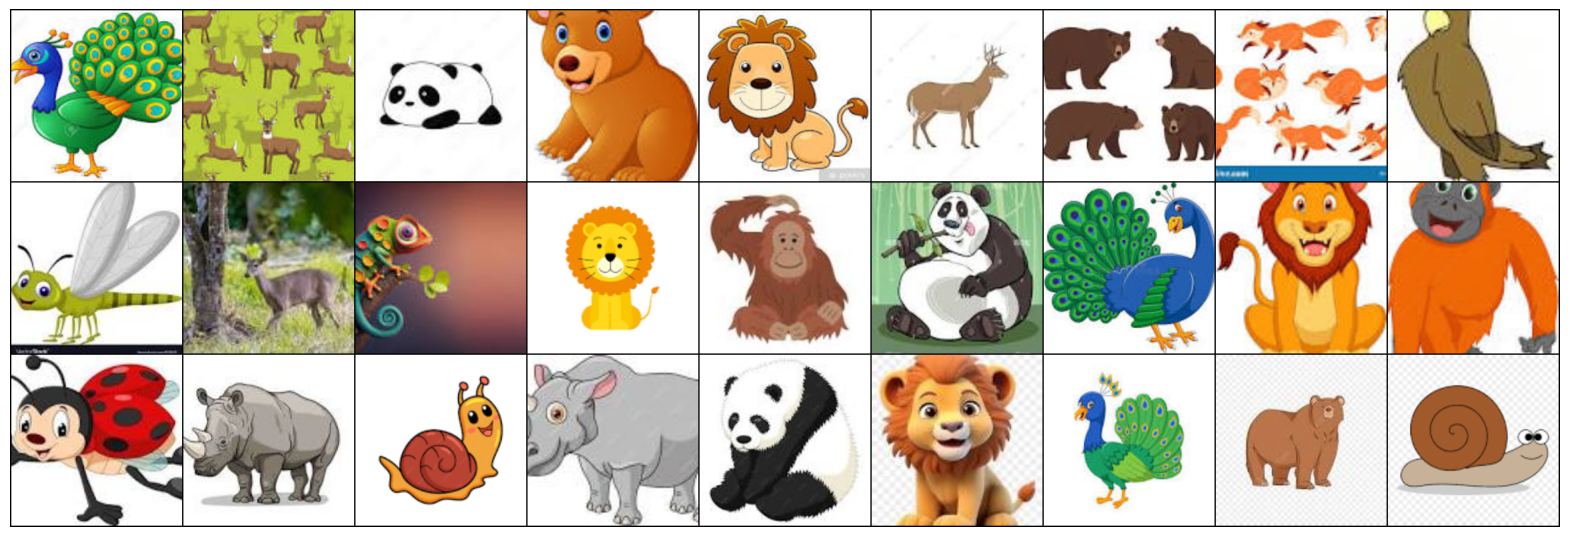

In [ ]:
sample_inputs, _ = next(iter(cartoon_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Got 61 / 400 correct of val set (15.25)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


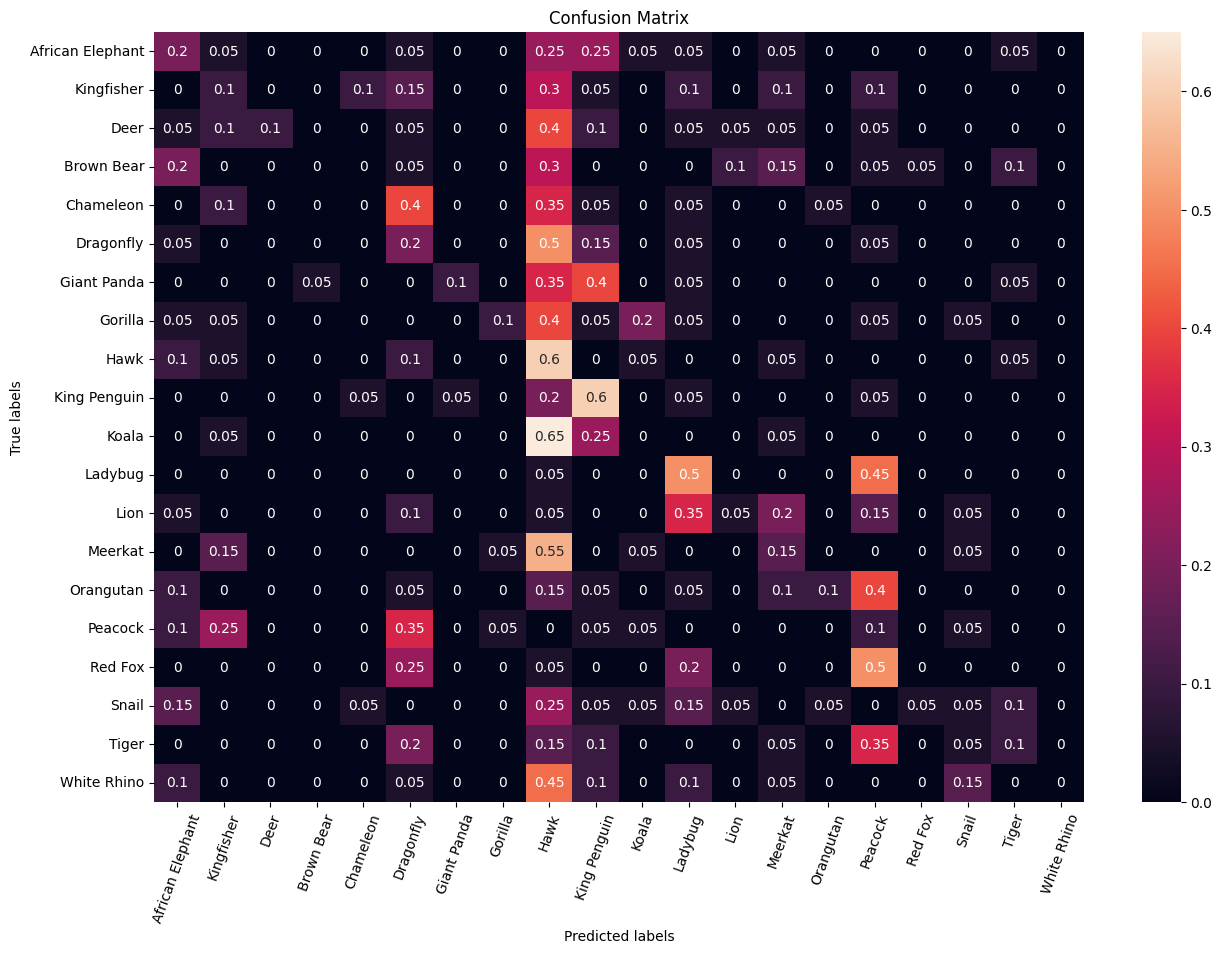

Predicted label ['King Penguin' 'King Penguin' 'Hawk' 'Peacock' 'Ladybug' 'Snail'
 'Kingfisher' 'Hawk' 'Hawk']
True label ['Deer' 'Dragonfly' 'Brown Bear' 'Orangutan' 'Lion' 'White Rhino' 'Hawk'
 'Giant Panda' 'Koala']
Corresponding images are shown below


0.1525

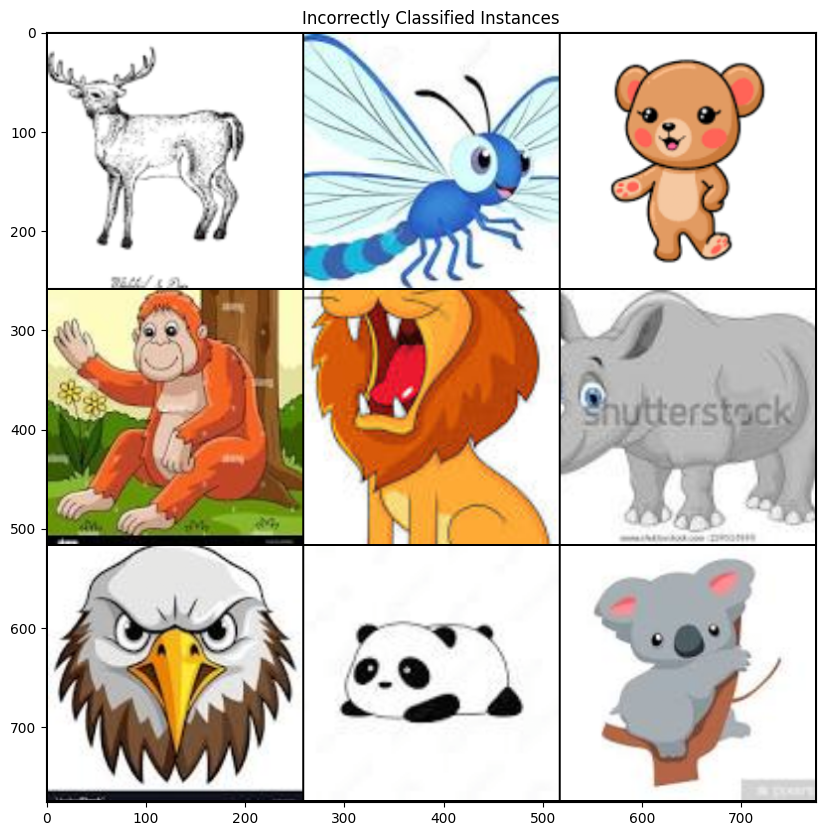

In [ ]:
check_accuracy(cartoon_loader, model, analysis=True)

**Answer:**

ANSWER HERE

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(:

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture).

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [209]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))


    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2

        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 640x480 with 0 Axes>

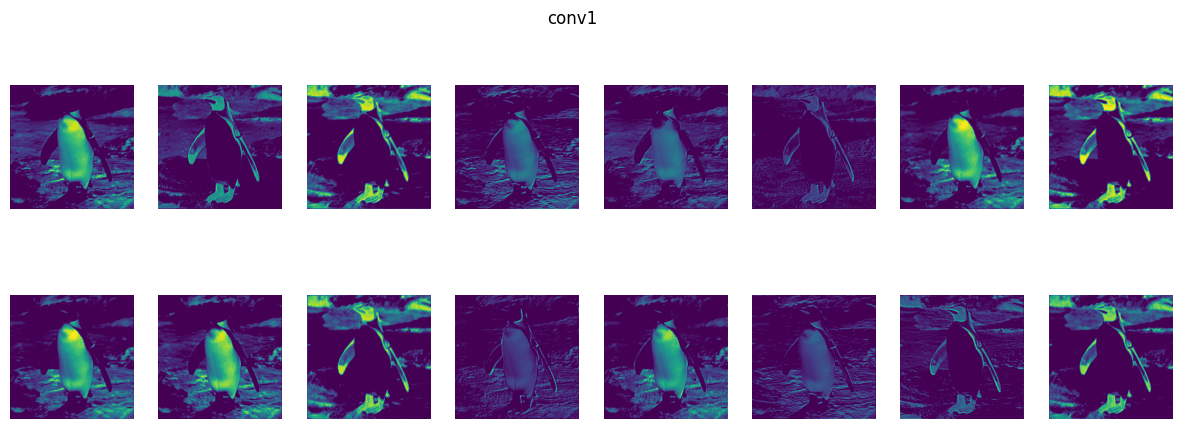

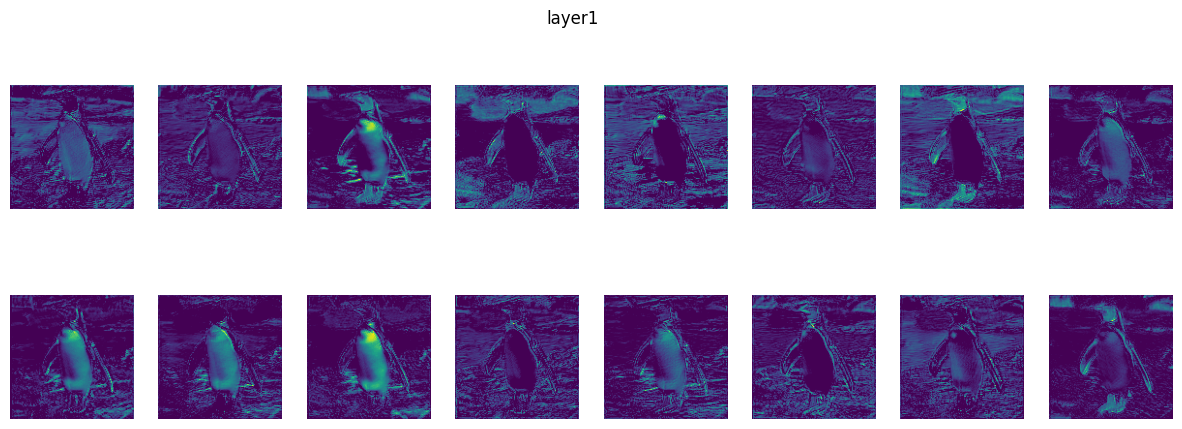

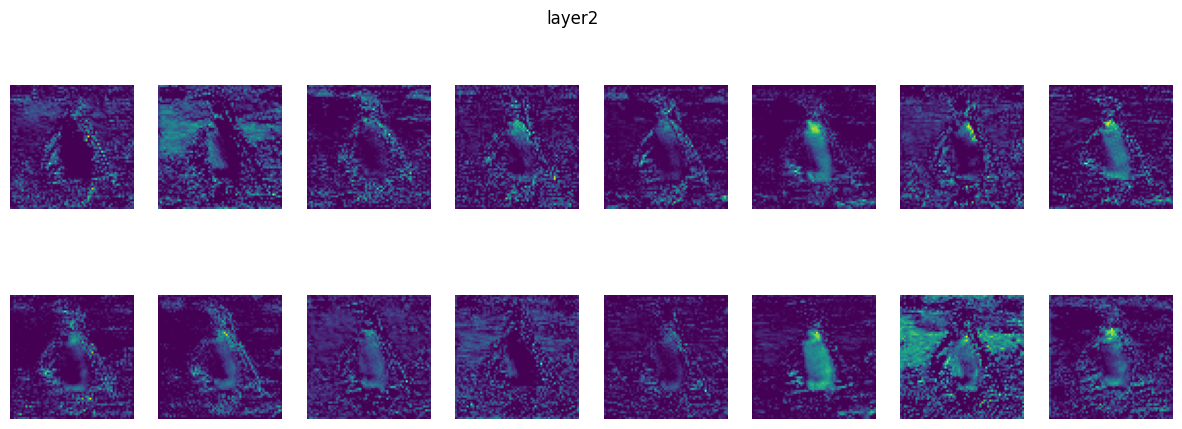

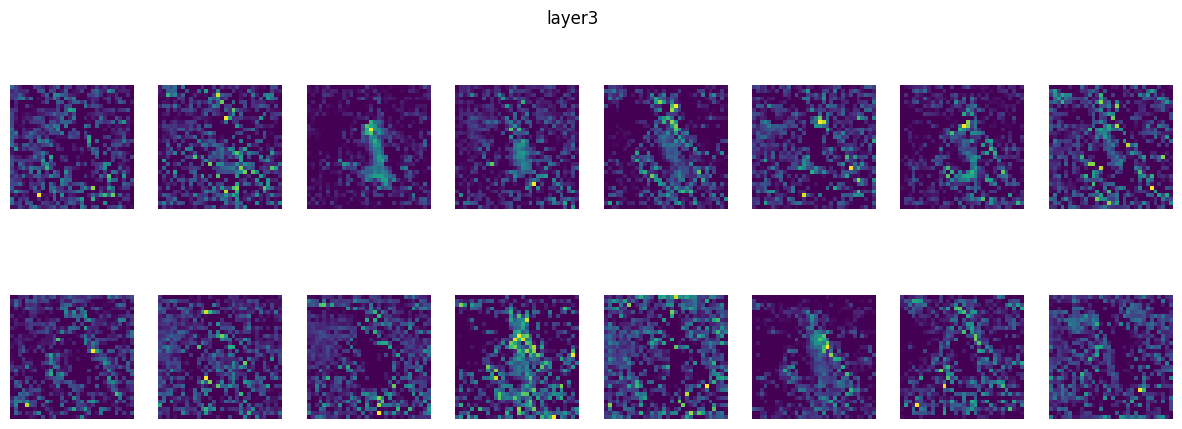

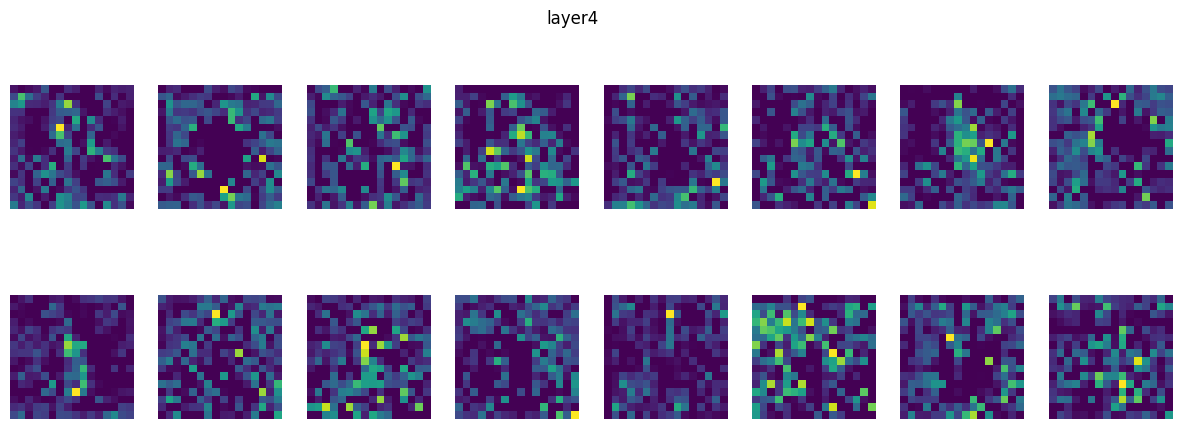

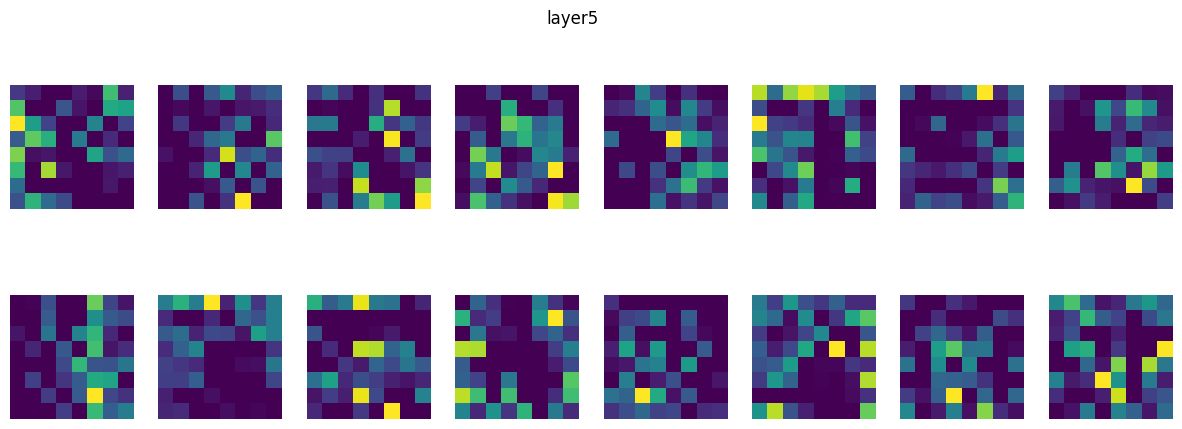

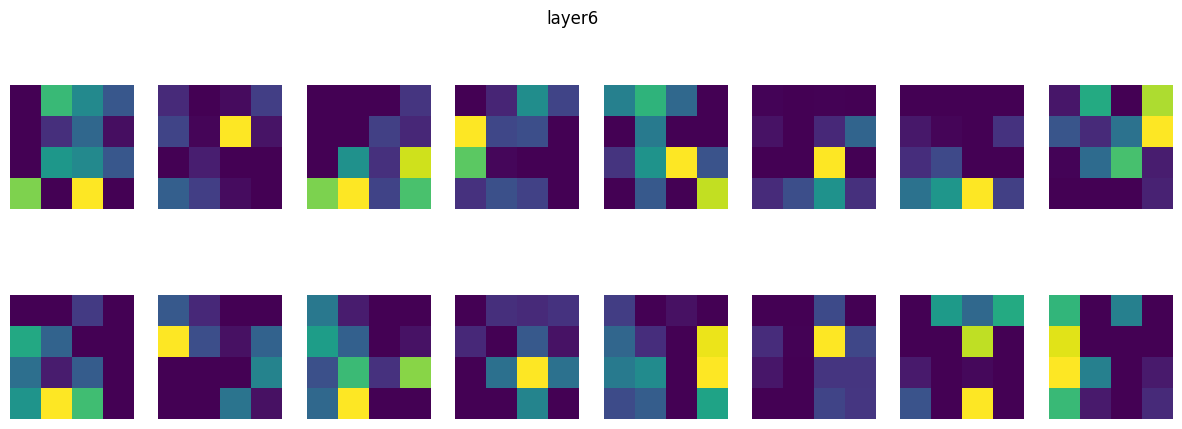

In [210]:
# Visualize the figure here, so it is exported nicely
plot_model_features()

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()